In [1]:
include("../../src/CoherentStructures.jl") #this is terrible but neccessary during development (?)

Main.CoherentStructures

In [2]:
using StreamMacros, Main.CoherentStructures
using Tensors, OrdinaryDiffEq
using Plots
using OrdinaryDiffEq

In [3]:
# Parameters
grid_resolution        = 100
quadrature_order       = 1
t₀                      = 0.6;    

In [4]:
rot_double_gyre = @velo_from_stream Ψ_rot_dgyre begin
    st          = heaviside(t)*heaviside(1-t)*t^2*(3-2*t) + heaviside(t-1)
    heaviside(x)= 0.5*(sign(x) + 1)
    Ψ_P         = sin(2π*x)*sin(π*y)
    Ψ_F         = sin(π*x)*sin(2π*y)
    Ψ_rot_dgyre = (1-st) * Ψ_P + st * Ψ_F
end
nothing

In [5]:
LL, UR = (0.0, 0.0), (1.0, 1.0)
ctx, _ = regularTriangularGrid((grid_resolution, grid_resolution), LL, UR, quadrature_order = quadrature_order);

In [6]:
function evaluate_on_grid(f,ctx)
    [f(node.x) for node in ctx.grid.nodes]
end

evaluate_on_grid (generic function with 1 method)

In [7]:
function l1_error(reference,solution)
    sum(sum([abs.(a .- b) for (a,b) in zip(reference,solution)])) / (2*length(reference))
end

l1_error (generic function with 1 method)

In [8]:
function l2_error(reference,solution)
    sum(sqrt.(sum([(a .- b).^2 for (a,b) in zip(reference,solution)]))) / (2*length(reference))
end

l2_error (generic function with 1 method)

In [9]:
function linfty_error(reference,solution)
    sum(maximum([(a .- b) for (a,b) in zip(reference,solution)]))
end

linfty_error (generic function with 1 method)

In [10]:
function T(solver, tolerance)
    return (x, param) -> flow(rot_double_gyre, x, [0.0, t₀ + param],
        tolerance=tolerance,solver=solver)[end]
end

T (generic function with 1 method)

In [11]:
function Tdot_reference(solver, tolerance, param)
   return x -> rot_double_gyre(T(solver, tolerance)(x,param),nothing,t₀+param) 
end

Tdot_reference (generic function with 1 method)

In [12]:
function Tdot_autodiff(solver, tolerance, param)
    return x -> Main.CoherentStructures.parameter_autodiff(T(solver, tolerance), x, param)
end

Tdot_autodiff (generic function with 1 method)

In [13]:
function Tdot_finite_differences(solver, tolerance, param, diff)
    return x -> 
     (T(solver, tolerance)(x, param+diff) .- T(solver, tolerance)(x, param-diff)) ./ (2*diff)
end

Tdot_finite_differences (generic function with 1 method)

In [15]:
tolerance_range_BS5 = [1e-1,1e-2,1e-3,1e-4,1e-5,1e-6,1e-7,1e-8,1e-9,1e-10,1e-11,1e-12,1e-13,1e-14];

In [16]:
reference_BS5 = [evaluate_on_grid(Tdot_reference(OrdinaryDiffEq.BS5(),tolerance,0),ctx) 
    for tolerance in tolerance_range_BS5];

In [17]:
autodiff_BS5    = [evaluate_on_grid(Tdot_autodiff(OrdinaryDiffEq.BS5(),tolerance,0),ctx) 
    for tolerance in tolerance_range_BS5]
FD_1eminus2_BS5 = [evaluate_on_grid(Tdot_finite_differences(OrdinaryDiffEq.BS5(),tolerance,0,1e-2),ctx)
    for tolerance in tolerance_range_BS5]
FD_1eminus3_BS5 = [evaluate_on_grid(Tdot_finite_differences(OrdinaryDiffEq.BS5(),tolerance,0,1e-3),ctx)
    for tolerance in tolerance_range_BS5]
FD_1eminus4_BS5 = [evaluate_on_grid(Tdot_finite_differences(OrdinaryDiffEq.BS5(),tolerance,0,1e-4),ctx) 
    for tolerance in tolerance_range_BS5]
FD_1eminus5_BS5 = [evaluate_on_grid(Tdot_finite_differences(OrdinaryDiffEq.BS5(),tolerance,0,1e-5),ctx)
    for tolerance in tolerance_range_BS5];
FD_1eminus6_BS5 = [evaluate_on_grid(Tdot_finite_differences(OrdinaryDiffEq.BS5(),tolerance,0,1e-6),ctx)
    for tolerance in tolerance_range_BS5];
FD_1eminus7_BS5 = [evaluate_on_grid(Tdot_finite_differences(OrdinaryDiffEq.BS5(),tolerance,0,1e-7),ctx)
    for tolerance in tolerance_range_BS5];

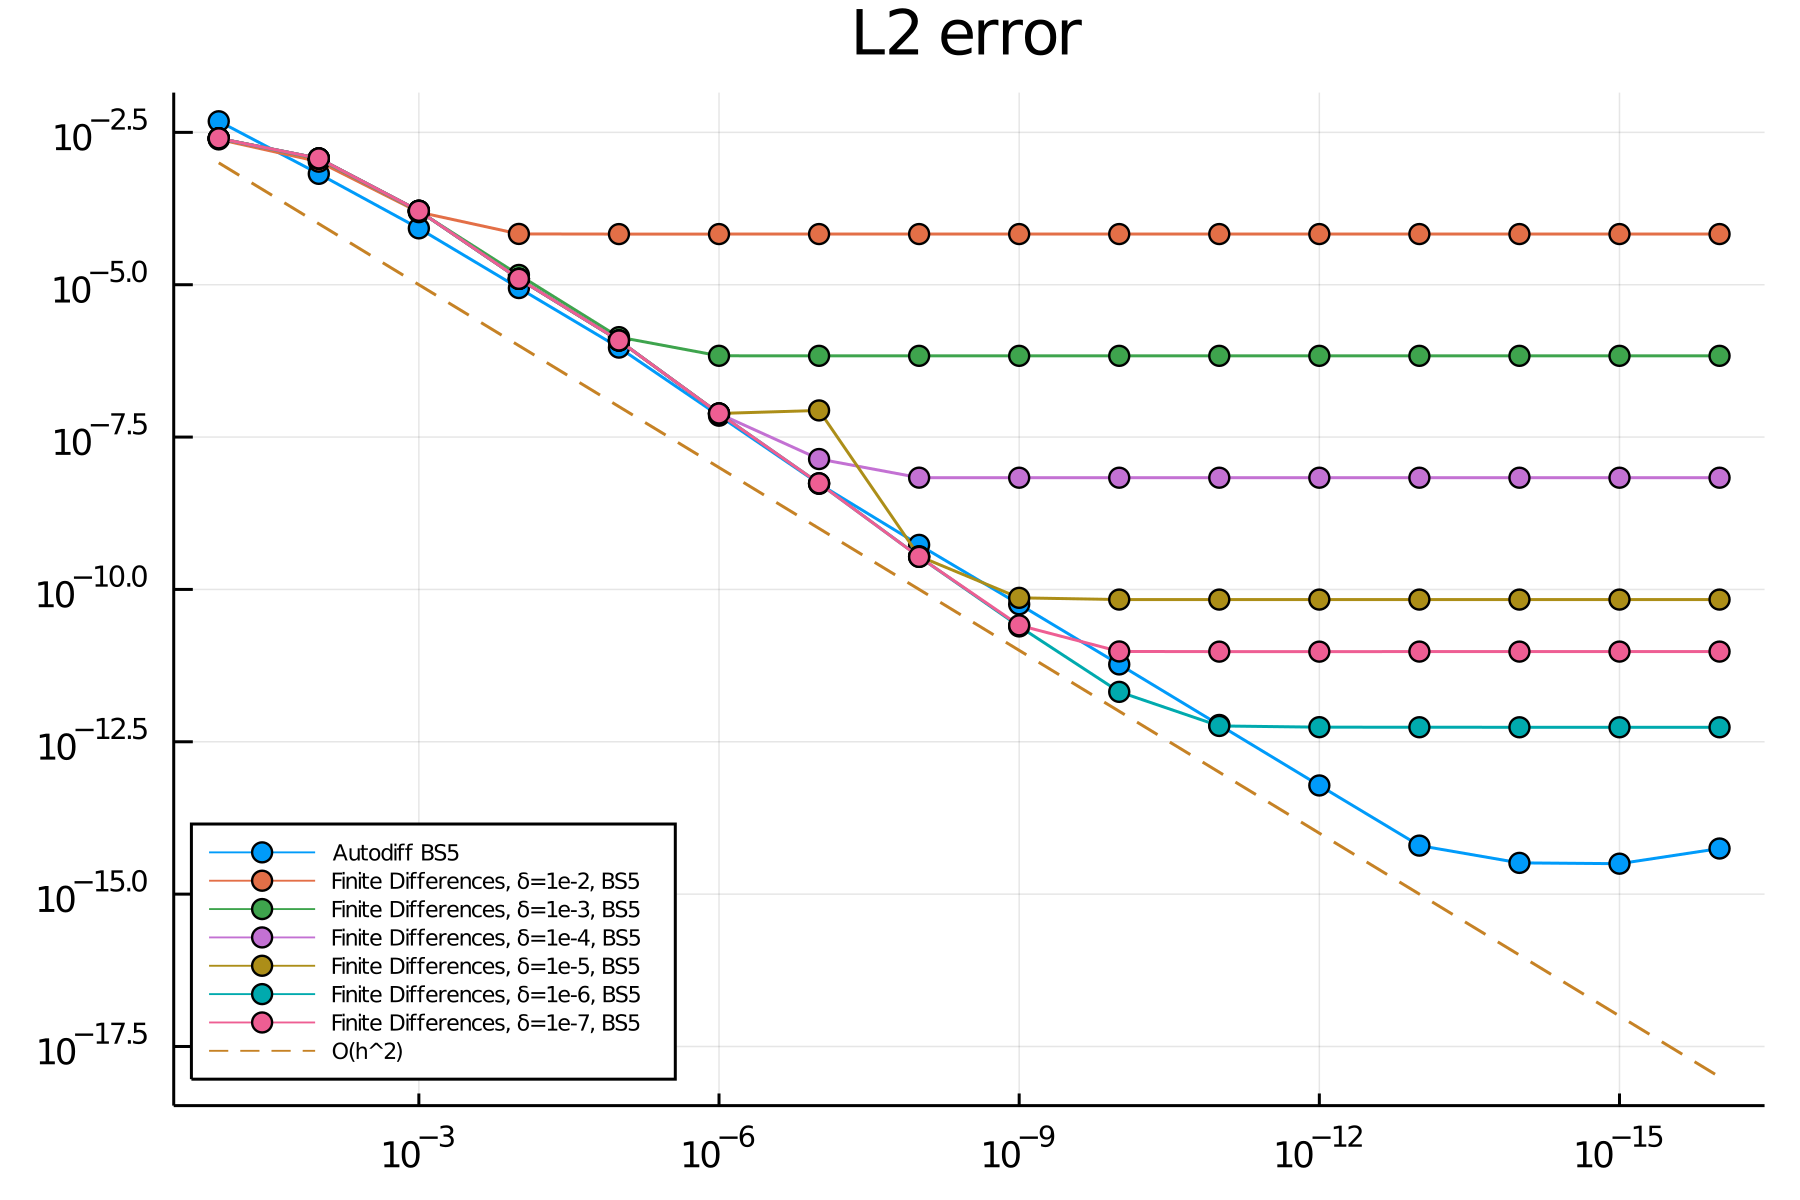

In [23]:
l2_plot_BS5 = Plots.plot(tolerance_range_BS5,[l2_error(ref_tol,tol) 
        for (ref_tol,tol) in zip(reference_BS5,autodiff_BS5)], 
    xaxis=:log, yaxis=:log, marker=:dot, xflip=true, label="Autodiff BS5"
    ,fmt=:png,dpi=300,title="L2 error",legend=(0.1,0.25),legendfontsize=5)
Plots.plot!(tolerance_range_BS5,[l2_error(ref_tol,tol)
        for (ref_tol,tol) in zip(reference_BS5,FD_1eminus2_BS5)], 
    marker=:dot, label="Finite Differences, δ=1e-2, BS5")
Plots.plot!(tolerance_range_BS5,[l2_error(ref_tol,tol)
         for (ref_tol,tol) in zip(reference_BS5,FD_1eminus3_BS5)], 
    marker=:dot, label="Finite Differences, δ=1e-3, BS5")
Plots.plot!(tolerance_range_BS5,[l2_error(ref_tol,tol)
         for (ref_tol,tol) in zip(reference_BS5,FD_1eminus4_BS5)], 
    marker=:dot, label="Finite Differences, δ=1e-4, BS5")
Plots.plot!(tolerance_range_BS5,[l2_error(ref_tol,tol)
         for (ref_tol,tol) in zip(reference_BS5,FD_1eminus5_BS5)], 
    marker=:dot, label="Finite Differences, δ=1e-5, BS5")
Plots.plot!(tolerance_range_BS5,[l2_error(ref_tol,tol)
         for (ref_tol,tol) in zip(reference_BS5,FD_1eminus6_BS5)], 
    marker=:dot, label="Finite Differences, δ=1e-6, BS5")
Plots.plot!(tolerance_range_BS5,[l2_error(ref_tol,tol)
         for (ref_tol,tol) in zip(reference_BS5,FD_1eminus7_BS5)], 
    marker=:dot, label="Finite Differences, δ=1e-7, BS5")
Plots.plot!(tolerance_range_BS5,[0.01x for x in tolerance_range_BS5], 
    linestyle=:dash,label="O(h)")

In [24]:
tolerance_range_DP8 = [1e-1,1e-2,1e-3,1e-4,1e-5,1e-6,1e-7,1e-8,1e-9,1e-10,1e-11,1e-12,1e-13,1e-14];

In [25]:
reference_DP8 = [evaluate_on_grid(Tdot_reference(OrdinaryDiffEq.DP8(),stepsize,0),ctx) 
    for stepsize in tolerance_range_DP8];

In [26]:
autodiff_DP8     = [evaluate_on_grid(Tdot_autodiff(OrdinaryDiffEq.DP8(),tolerance,0),ctx) 
    for tolerance in tolerance_range_DP8]
FD_1eminus2_DP8 = [evaluate_on_grid(Tdot_finite_differences(OrdinaryDiffEq.DP8(),tolerance,0,1e-2),ctx)
    for tolerance in tolerance_range_DP8]
FD_1eminus3_DP8 = [evaluate_on_grid(Tdot_finite_differences(OrdinaryDiffEq.DP8(),tolerance,0,1e-3),ctx)
    for tolerance in tolerance_range_DP8]
FD_1eminus4_DP8 = [evaluate_on_grid(Tdot_finite_differences(OrdinaryDiffEq.DP8(),tolerance,0,1e-4),ctx) 
    for tolerance in tolerance_range_DP8]
FD_1eminus5_DP8 = [evaluate_on_grid(Tdot_finite_differences(OrdinaryDiffEq.DP8(),tolerance,0,1e-5),ctx)
    for tolerance in tolerance_range_DP8];
FD_1eminus6_DP8 = [evaluate_on_grid(Tdot_finite_differences(OrdinaryDiffEq.DP8(),tolerance,0,1e-6),ctx)
    for tolerance in tolerance_range_DP8];
FD_1eminus7_DP8 = [evaluate_on_grid(Tdot_finite_differences(OrdinaryDiffEq.DP8(),tolerance,0,1e-7),ctx)
    for tolerance in tolerance_range_DP8];

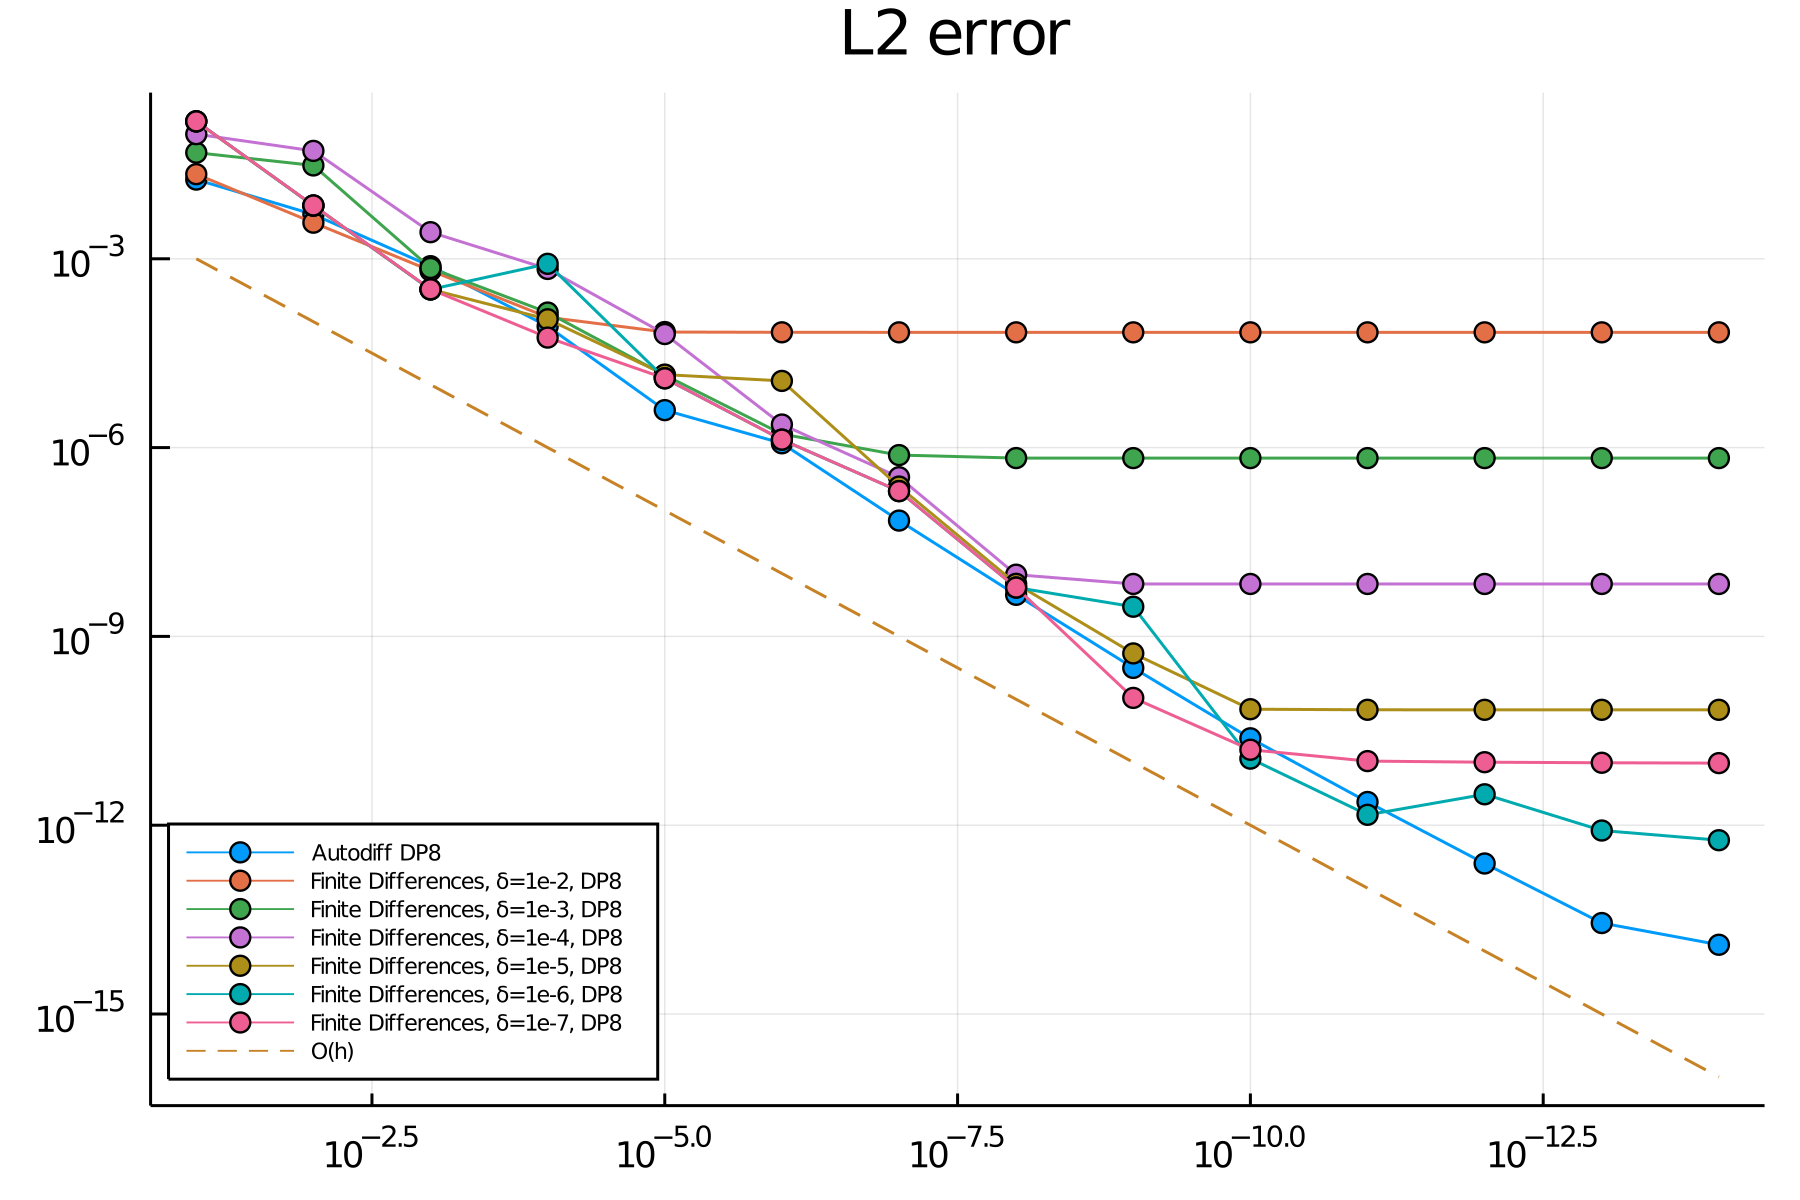

In [34]:
l2_plot_DP8 = Plots.plot(tolerance_range_DP8,[l2_error(ref_tol,tol) 
        for (ref_tol,tol) in zip(reference_DP8,autodiff_DP8)], 
    xaxis=:log, yaxis=:log, marker=:dot, xflip=true, label="Autodiff DP8"
    ,fmt=:png,dpi=300,title="L2 error",legend=(0.1,0.25),legendfontsize=5)
Plots.plot!(tolerance_range_DP8,[l2_error(ref_tol,tol) 
        for (ref_tol,tol) in zip(reference_DP8,FD_1eminus2_DP8)], 
    marker=:dot, label="Finite Differences, δ=1e-2, DP8")
Plots.plot!(tolerance_range_DP8,[l2_error(ref_tol,tol) 
         for (ref_tol,tol) in zip(reference_DP8,FD_1eminus3_DP8)], 
    marker=:dot, label="Finite Differences, δ=1e-3, DP8")
Plots.plot!(tolerance_range_DP8,[l2_error(ref_tol,tol)
         for (ref_tol,tol) in zip(reference_DP8,FD_1eminus4_DP8)], 
    marker=:dot, label="Finite Differences, δ=1e-4, DP8")
Plots.plot!(tolerance_range_DP8,[l2_error(ref_tol,tol)
         for (ref_tol,tol) in zip(reference_DP8,FD_1eminus5_DP8)], 
    marker=:dot, label="Finite Differences, δ=1e-5, DP8")
Plots.plot!(tolerance_range_DP8,[l2_error(ref_tol,tol)
         for (ref_tol,tol) in zip(reference_DP8,FD_1eminus6_DP8)], 
    marker=:dot, label="Finite Differences, δ=1e-6, DP8")
Plots.plot!(tolerance_range_DP8,[l2_error(ref_tol,tol)
         for (ref_tol,tol) in zip(reference_DP8,FD_1eminus7_DP8)], 
    marker=:dot, label="Finite Differences, δ=1e-7, DP8")
Plots.plot!(tolerance_range_DP8,[0.01x for x in tolerance_range_DP8], 
    linestyle=:dash,label="O(h)")

In [28]:
tolerance_range_Vern7 =  [1e-1,1e-2,1e-3,1e-4,1e-5,1e-6,1e-7,1e-8,1e-9,1e-10,1e-11,1e-12,1e-13,1e-14];

In [29]:
reference_Vern7 = [evaluate_on_grid(Tdot_reference(OrdinaryDiffEq.Vern7(),tolerance,0),ctx) 
    for tolerance in tolerance_range_Vern7];

In [35]:
autodiff_Vern7     = [evaluate_on_grid(Tdot_autodiff(OrdinaryDiffEq.Vern7(),tolerance,0),ctx) 
    for tolerance in tolerance_range_Vern7]
FD_1eminus2_Vern7 = [evaluate_on_grid(Tdot_finite_differences(OrdinaryDiffEq.Vern7(),tolerance,0,1e-2),ctx)
    for tolerance in tolerance_range_Vern7]
FD_1eminus3_Vern7 = [evaluate_on_grid(Tdot_finite_differences(OrdinaryDiffEq.Vern7(),tolerance,0,1e-3),ctx)
    for tolerance in tolerance_range_Vern7]
FD_1eminus4_Vern7 = [evaluate_on_grid(Tdot_finite_differences(OrdinaryDiffEq.Vern7(),tolerance,0,1e-4),ctx) 
    for tolerance in tolerance_range_Vern7]
FD_1eminus5_Vern7 = [evaluate_on_grid(Tdot_finite_differences(OrdinaryDiffEq.Vern7(),tolerance,0,1e-5),ctx)
    for tolerance in tolerance_range_Vern7];
FD_1eminus6_Vern7 = [evaluate_on_grid(Tdot_finite_differences(OrdinaryDiffEq.Vern7(),tolerance,0,1e-6),ctx)
    for tolerance in tolerance_range_Vern7];
FD_1eminus7_Vern7 = [evaluate_on_grid(Tdot_finite_differences(OrdinaryDiffEq.Vern7(),tolerance,0,1e-7),ctx)
    for tolerance in tolerance_range_Vern7];

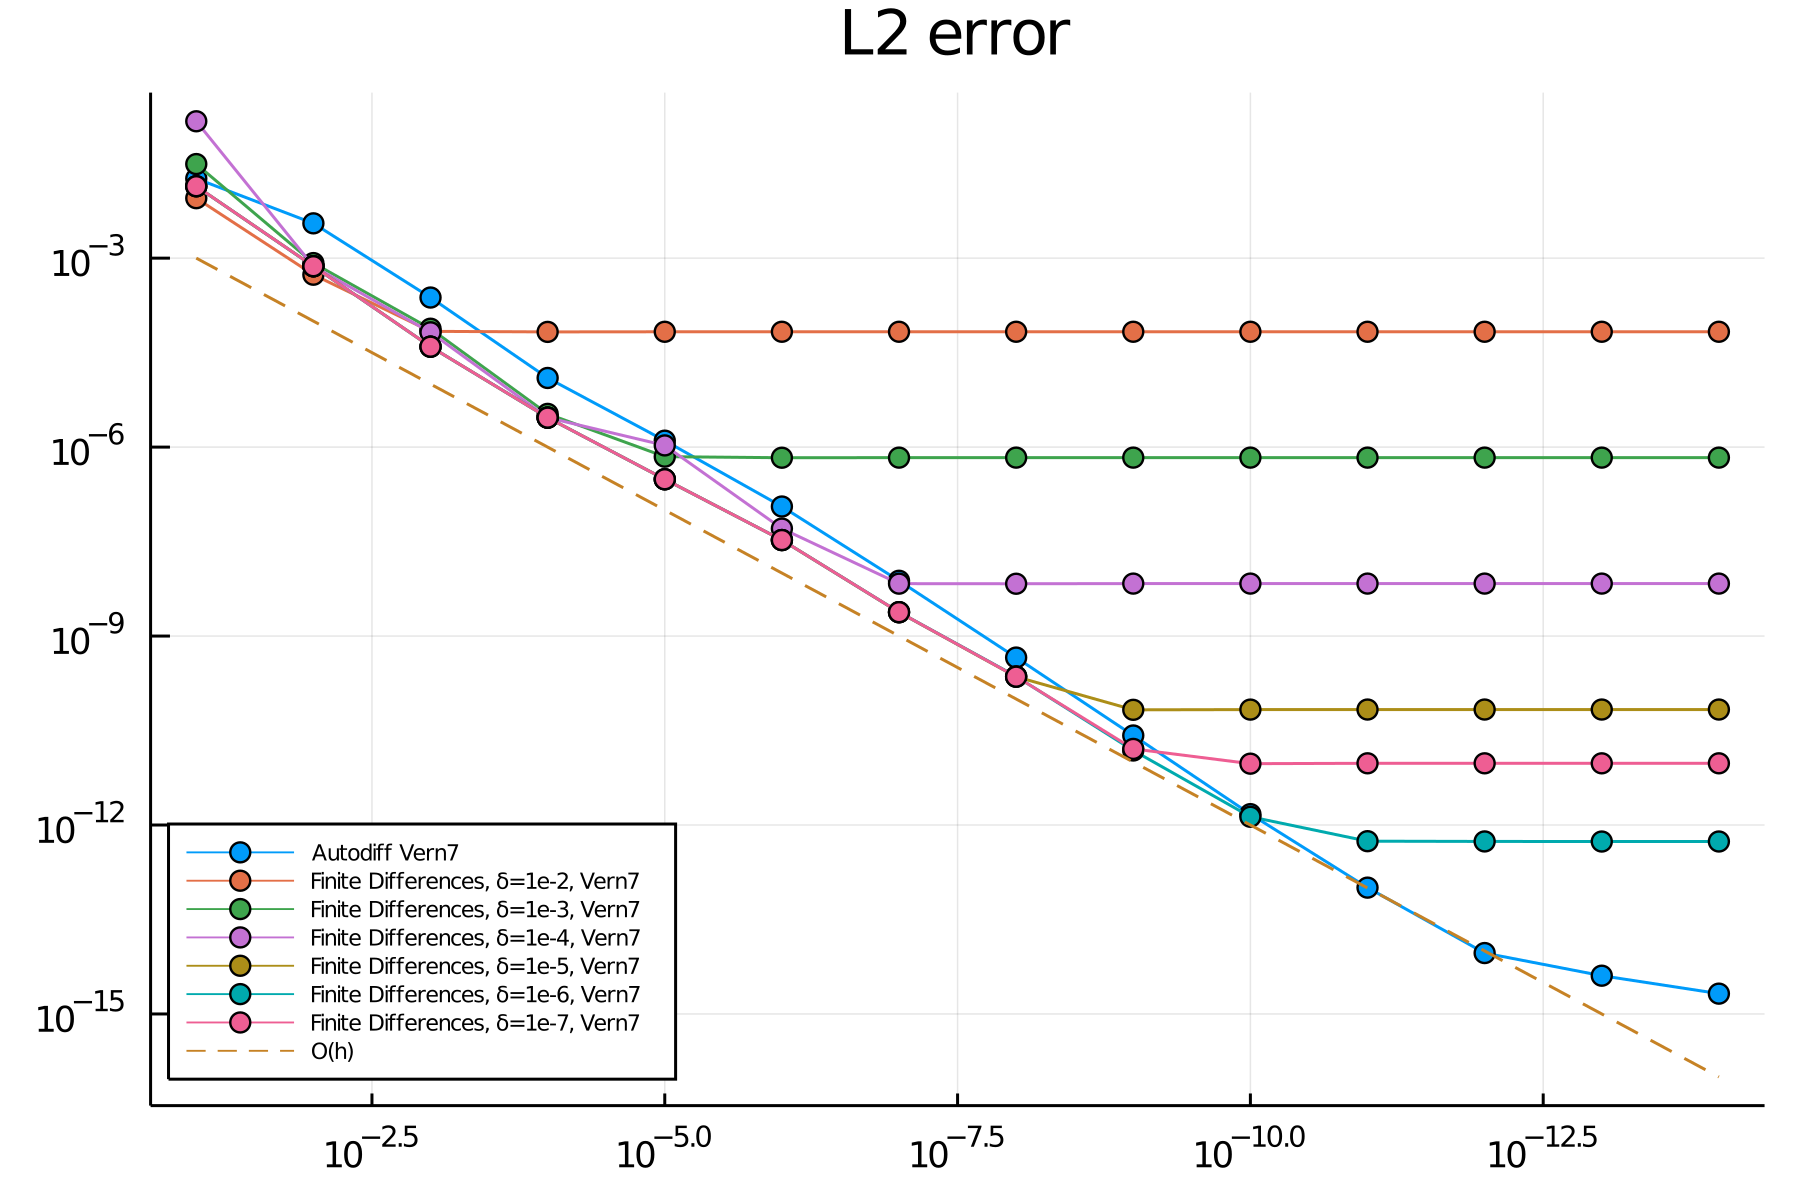

In [41]:
l2_plot_Vern7 = Plots.plot(tolerance_range_Vern7,[l2_error(ref_tol,tol) 
        for (ref_tol,tol) in zip(reference_Vern7,autodiff_Vern7)], 
    xaxis=:log, yaxis=:log, marker=:dot, xflip=true, label="Autodiff Vern7"
    ,fmt=:png,dpi=300,title="L2 error",legend=(0.1,0.25),legendfontsize=5)
Plots.plot!(tolerance_range_Vern7,[l2_error(ref_tol,tol) 
        for (ref_tol,tol) in zip(reference_Vern7,FD_1eminus2_Vern7)], 
    marker=:dot, label="Finite Differences, δ=1e-2, Vern7")
Plots.plot!(tolerance_range_Vern7,[l2_error(ref_tol,tol)
         for (ref_tol,tol) in zip(reference_Vern7,FD_1eminus3_Vern7)], 
    marker=:dot, label="Finite Differences, δ=1e-3, Vern7")
Plots.plot!(tolerance_range_Vern7,[l2_error(ref_tol,tol)
         for (ref_tol,tol) in zip(reference_Vern7,FD_1eminus4_Vern7)], 
    marker=:dot, label="Finite Differences, δ=1e-4, Vern7")
Plots.plot!(tolerance_range_Vern7,[l2_error(ref_tol,tol)
         for (ref_tol,tol) in zip(reference_Vern7,FD_1eminus5_Vern7)], 
    marker=:dot, label="Finite Differences, δ=1e-5, Vern7")
Plots.plot!(tolerance_range_Vern7,[l2_error(ref_tol,tol) 
         for (ref_tol,tol) in zip(reference_Vern7,FD_1eminus6_Vern7)], 
    marker=:dot, label="Finite Differences, δ=1e-6, Vern7")
Plots.plot!(tolerance_range_Vern7,[l2_error(ref_tol,tol)
         for (ref_tol,tol) in zip(reference_Vern7,FD_1eminus7_Vern7)], 
    marker=:dot, label="Finite Differences, δ=1e-7, Vern7")
Plots.plot!(tolerance_range_Vern7,[0.01x for x in tolerance_range_Vern7], 
    linestyle=:dash,label="O(h)")